In [2]:

import os, random, itertools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split



C:\Users\naikk\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\naikk\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\naikk\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [3]:
# Part 2: Load MNIST
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train_full.shape, y_train_full.shape, x_test.shape, y_test.shape


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

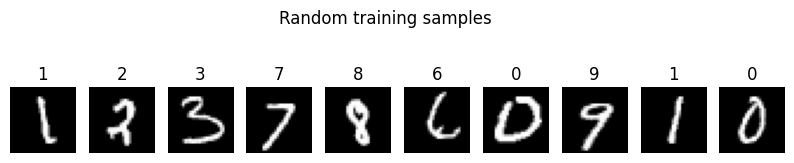

In [4]:
# Peek at a few samples
plt.figure(figsize=(10,2))
for i in range(10):
    idx = np.random.randint(0, x_train_full.shape[0])
    plt.subplot(1,10,i+1)
    plt.imshow(x_train_full[idx], cmap='gray')
    plt.title(int(y_train_full[idx]))
    plt.axis('off')
plt.suptitle("Random training samples", y=1.05)
plt.show()


In [5]:
# Part 3: Prepare data
# Scale to [0,1] and add channel dimension for CNNs: (H, W) -> (H, W, 1)
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_full = np.expand_dims(x_train_full, -1)
x_test = np.expand_dims(x_test, -1)

# Create a validation split from the original training set
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)

x_train.shape, x_val.shape, x_test.shape


((54000, 28, 28, 1), (6000, 28, 28, 1), (10000, 28, 28, 1))

In [6]:
# Part 4: Baseline CNN
def make_baseline_model():
    inputs = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name="baseline_cnn")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

baseline_model = make_baseline_model()
baseline_model.summary()


Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Part 5: Callbacks
ckpt_path = "best_mnist_baseline.keras"
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1),
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_accuracy')
]


In [8]:
# Part 6: Train
history = baseline_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/20
422/422 - 19s - 45ms/step - accuracy: 0.9234 - loss: 0.2463 - val_accuracy: 0.9787 - val_loss: 0.0772 - learning_rate: 1.0000e-03
Epoch 2/20
422/422 - 15s - 36ms/step - accuracy: 0.9775 - loss: 0.0734 - val_accuracy: 0.9843 - val_loss: 0.0510 - learning_rate: 1.0000e-03
Epoch 3/20
422/422 - 15s - 36ms/step - accuracy: 0.9843 - loss: 0.0527 - val_accuracy: 0.9855 - val_loss: 0.0506 - learning_rate: 1.0000e-03
Epoch 4/20
422/422 - 15s - 36ms/step - accuracy: 0.9866 - loss: 0.0414 - val_accuracy: 0.9837 - val_loss: 0.0530 - learning_rate: 1.0000e-03
Epoch 5/20
422/422 - 15s - 36ms/step - accuracy: 0.9890 - loss: 0.0340 - val_accuracy: 0.9885 - val_loss: 0.0424 - learning_rate: 1.0000e-03
Epoch 6/20
422/422 - 15s - 35ms/step - accuracy: 0.9908 - loss: 0.0295 - val_accuracy: 0.9882 - val_loss: 0.0392 - learning_rate: 1.0000e-03
Epoch 7/20
422/422 - 15s - 36ms/step - accuracy: 0.9923 - loss: 0.0238 - val_accuracy: 0.9892 - val_loss: 0.0399 - learning_rate: 1.0000e-03
Epoch 8/20

E

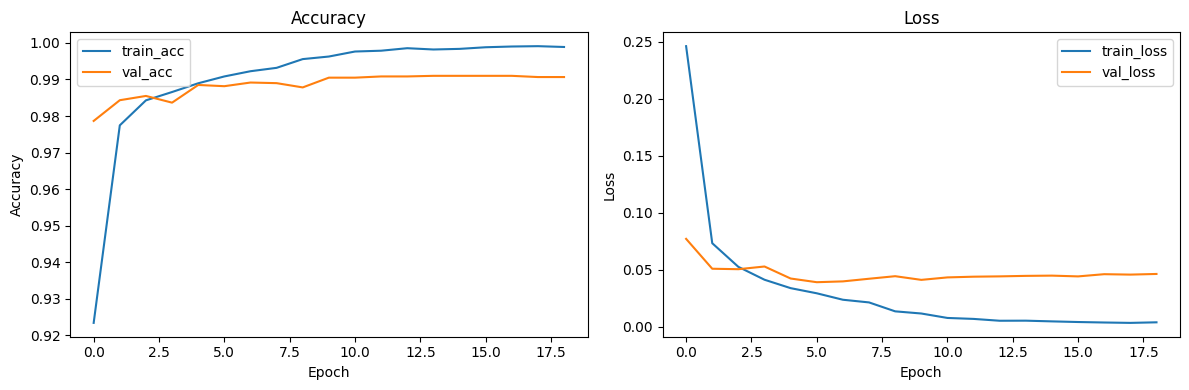

In [9]:
# Plot learning curves
def plot_history(h):
    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')
    # Loss
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')
    plt.tight_layout()
    plt.show()

plot_history(history)


In [10]:
# Part 7: Test evaluation
test_loss, test_acc = baseline_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


Test Accuracy: 0.9922 | Test Loss: 0.0237


In [11]:
# Predictions & detailed metrics
y_pred_probs = baseline_model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9939    0.9980    0.9959       980
           1     0.9974    0.9991    0.9982      1135
           2     0.9923    0.9932    0.9927      1032
           3     0.9931    0.9931    0.9931      1010
           4     0.9949    0.9919    0.9934       982
           5     0.9888    0.9899    0.9894       892
           6     0.9968    0.9906    0.9937       958
           7     0.9874    0.9893    0.9883      1028
           8     0.9887    0.9908    0.9897       974
           9     0.9881    0.9851    0.9866      1009

    accuracy                         0.9922     10000
   macro avg     0.9921    0.9921    0.9921     10000
weighted avg     0.9922    0.9922    0.9922     10000



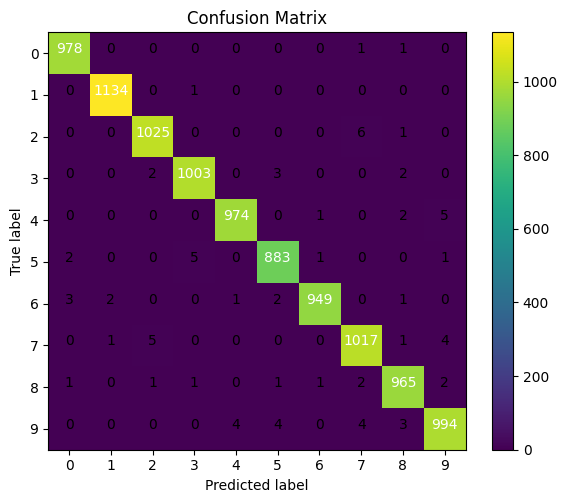

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, [str(i) for i in range(10)])
plt.yticks(tick_marks, [str(i) for i in range(10)])
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
